# 002 - Feature Engineering and Data Pre-Processing
This workbook introduces you to the basics of Feature Engineering

## What is a Feature
With Deep Learning we provide a model with a set of _training examples_ (or instances); each example contains a set of data related to that example.

For example, consider the following data that we could use to train a model:

|temperature|month|day|rain|snow|wind speed|wind direction|
|---|---|---|---|---|---|---|
|15|September|21|0|0|5|SW|
|9|September|22|2|0|16|SW|
|21|September|23|4|0|5|NE|

If we were building a model to preduct the temperature (the __target__) we could use the data in the other columns to make that prediction. The columns _month_, _day_, _rain_, _snow_, _wind speed_ and _wind direction_ are all __Features__

Each row is a training sample and each sample has the same set of Features.

## Why Engineer Features?
Usually when we talk about Feature Engineering we are concerned with using our existing knowedlge about the Domain to create new Features to aid learning. This knowledge can reduce the complexity of the data.

For example, consider a model where we want to predict the time it will take to travel between 2 points in a city based on the time of the year, time of the day and the GPS co-ordinates for the pick-up and drop-off locations. 

As Domain Experts we might look at the available data and decide that to aid learning we probably need some additional Features such as:
* the distance between the pick-up and drop-off points. We don't have the route but we can estimate this based on the distance between the two points. The road network in the city is quite dense so this is a good approximation.
* Pick-up & Drop Off Zones since the the GPS co-ordinates are quite accurate but in reality there is little difference between a pick-ups that are close to each other (e.g. within 100m). Uncovering a releationship using the fine grained GPS co-ordinates may be problematic. So we could Zone or sectorise the map in some way and engineer a higher level feature for each trip as a zone to zone trip rather than GPS to GPS. This might be just as accurate for the job and we could then simplify our data by removing the GPS co-ordinates from the training Features.

While Feature Engineering seems like a good idea, there is a risk that by doing this we loose an oppertunity to uncover some new relationships or bias the learned model to existing (possibly outdated) domain models.

## Pre-processing data
Real-world data is messy and comes in a variety of forms, not all of which are useful for Machine Learning and so it's often the case that we need to perform some Data Pre-Processing before we can use the data for learning.

Common Pre-Processing tasks include:
* Getting rid of data that is not relevant to the task
* Converting Categorical Data into a numerical representation
* Normalising numerical data so it has similar scales and shapes
* Dealing with missing data for features
* Encoding non-numerical data (e.g. words) into a numerical format

What ever processing we do for the training data we must remember to do the same pre-processing on data we use to test and evaluate our model.

## Exercises
This workbook contains a set of exercises designed to show both Feature Engineering and Data Pre-Processing in action.

Since, this course does not expect development skills in Python you will not be expected to write the feature engineering or data pre-processing methods yourself. However you will want to be able to recognise what needs to be done and use pre-created functions during future exercises.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
import os

## Get our dataset
We have a data set containing a range of values to experiment with Feature Engineering and Data Pre-processing.
We are using the __Pandas__ library to perfom our data pre-processing since it contains various functions to help with data pre-processing and feature engineering.

In [9]:
zip_file = tf.keras.utils.get_file(origin="https://github.com/BillMatthews/ml-course/blob/master/taxi.zip",
                                    fname="taxi.zip", extract=True)

base_dir, _ = os.path.splitext(zip_file)
data_file = os.path.join(base_dir, 'taxi.csv')
print(data_file)
data = pd.read_csv("taxi.csv", parse_dates=['pickup_datetime'],)
data.head()

C:\Users\Bill\.keras\datasets\taxi\taxi.csv


FileNotFoundError: [Errno 2] File b'taxi.csv' does not exist: b'taxi.csv'

## Data Preprocessing exercises
### Exercise: Dealing with missing data
First we want to see if there are is any missing data. 

We can use the _Pandas_ __isnull()__ method to determine this and group by feature using the following command.


We can see that there are 5 training examples where the _dropoff_longitude_ or _dropoff_latitude_ contain null values. These are not going to be any use to us.

We generally have 4 options:
* Delete the rows with null data
* Remove the feature from the dataset
* Replace the null values with some suitable value (e.g. some median/average value)
* Replace the null values with some predicted value (e.g. use another model to predict the likely value)

Each of these are appropraite methods for dealing with null data. As a hueristic:
- if the number of rows is small (compared to the overall data set), then deleting the values is usally appropriate.
   - this is the most straightforward option but reduces the amount of data available for training
- If you have a large number of missing values for a feature, consider removing the feature
    - this is straightforward to do but if the presence of the data is important to the model then our model may not be as accurate.
- If we can approximate or predict a value then do this
    - depending upon the number of missing values this might bias the learning.

__Question:__ What should we do about the the training samples with null values? Can we easily predict/estimate values for these?


In [3]:
print(data.isnull().sum())

print("\nTotal samples: {}".format(data.shape[0]))

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
dtype: int64

Total samples: 500000


In our example we will drop these values - but make sure you understand why

In [4]:
# This will drop any rows with nulls
data = data.dropna()

print(data.isnull().sum())
print("\nTotal samples: {}".format(data.shape[0]))

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

Total samples: 499995


### Dealing with invalid data
If we summarise our data we can see that there are some issues with the data:

Similar to dealing with null values, we can deal with invalid data in one of 4 ways:
- Delete the rows with invalid data
- Remove the feature from the dataset
- Replace the null values with some suitable value (e.g. some median/average value)
- Replace the null values with some predicted value (e.g. use another model to predict the likely value)

__Question__: what problems do you see in the data - hint, look at the min and max values for each feature.

__Question__: Of the above options, how do you think we should deal with the invalid data for each Feature?

In [5]:
print(data.describe())

         fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  499995.000000     499995.000000    499995.000000      499995.000000   
mean       11.358182        -72.520091        39.920350         -72.522435   
std         9.916069         11.856446         8.073318          11.797362   
min       -44.900000      -2986.242495     -3116.285383       -3383.296608   
25%         6.000000        -73.992047        40.734916         -73.991382   
50%         8.500000        -73.981785        40.752670         -73.980126   
75%        12.500000        -73.967117        40.767076         -73.963572   
max       500.000000       2140.601160      1703.092772          40.851027   

       dropoff_latitude  passenger_count  
count     499995.000000    499995.000000  
mean          39.916526         1.683445  
std            7.391002         1.307391  
min        -2559.748913         0.000000  
25%           40.734057         1.000000  
50%           40.753152         1.00000

### Dealing with invalid fares
The __fare_amount__ has a range between $-44.9 and $500. It is clear that any fare below 0 is invalid; in fact there is usaully an initial charge for a taxi (approx $2.5) so it's likely that any fares below that figure are invalid. 

We could also argue that very large fares are also _potentially_ invalid and so we may want to limit our range to fares that are below some value such as $50.00.

We could replace these with the mean value (£11.35) but since the fare is likely to be related to the distance travelled we might skew the results if we follow a replacement strategy like this.

So let's check how many fares are below $2.50 and see if we can safely drop these rows.

In [6]:
print (data[data['fare_amount'] < 2.5].shape[0])

41


In [7]:
# There are only 41 records (out of nearly 0.5 million) so let's delete these
data = data[data['fare_amount'] >= 2.5]
print("\nTotal samples: {}".format(data.shape[0]))


Total samples: 499954


### Dealing with invalid Longitude and Latitudes
The data is from New York City which exists between approximately:
- Longitude -74.05 and -73.75
- Latitude 40.63 and 40.85

However looking at the stats from the data we have data that is considerably outside this and actually invalid (long and lat values are in the range -90 to +90). So we can consider anything outside of these as invalid.

It's unlikely that we can provide reasonable defaults or estimate these and additionally we need these to determine the distance travelled. Therefore we need to consider deleting these records.

In [8]:
# range of longitude for NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# range of latitude for NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

# The processing to strip out long and lat is complex so we will create a function to do this
def get_NYC_records_only(dataset):
    # Create a copy and leave the original alone
    df2 = dataset.copy(deep=True)

    for long in ['pickup_longitude', 'dropoff_longitude']:
        df2 = df2[(df2[long] > nyc_min_longitude) & (df2[long] < nyc_max_longitude)]

    for lat in ['pickup_latitude', 'dropoff_latitude']:
        df2 = df2[(df2[lat] > nyc_min_latitude) & (df2[lat] < nyc_max_latitude)]
    
    return df2


# Determine how many records are outside the Long and Lat for NYC
nyc_data = get_NYC_records_only(data)
num_nyc_records = nyc_data.shape[0]
all_records = data.shape[0]
outside_nyc_records = all_records - num_nyc_records
percentage_outside = outside_nyc_records / all_records * 100

print("Outside NYC longitude: {}".format(outside_nyc_records))
print("Percentage outside NYC longitude: {:0f}".format(percentage_outside))

Outside NYC longitude: 16488
Percentage outside NYC longitude: 3.297903


That's about 3% of our records are outside the target area - we don't really have much choice but to delete them.

In [9]:
data = get_NYC_records_only(data)
print("\nTotal samples: {}".format(data.shape[0]))


Total samples: 483466


### Dealing with invalid Passenger Count
We can see that there are some records where the passenger count is 0 which seems odd.

They could be trips made to deliver some package rather than to carry a passenger but that seems rare in this day due to the security concerns of doing that.

Records with 0 passengers: 1732


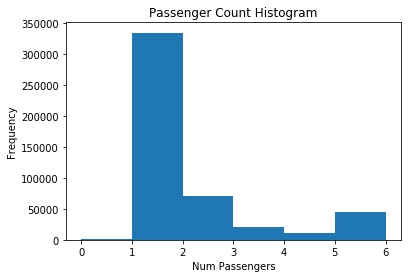

In [10]:
print("Records with 0 passengers: {}".format(data[data['passenger_count'] < 1.0].shape[0]))

data['passenger_count'].plot.hist(bins=6)
plt.xlabel('Num Passengers')
plt.title('Passenger Count Histogram')
plt.show()

With 1,700 records falling into the category we could just delete the rows but ideally we want to keep as much data as possible. We could estimate the number of passengers instead. From the statistics and the above graph we can we can see that the average/mean value is 1.6 passengers and actually by far the most common is a single passenger.

So replacing any 0 passenger count values a value of 1 acceptable and the number of records shouldn't bias our model much.

In [11]:
# Get the mode (the most frequent value)
mode = data['passenger_count'].mode().values[0]
# Set the passenger count to the mode where the passenger count is currently 0
data.loc[data['passenger_count'] == 0, 'passenger_count'] = mode

### Dealing with un-needed features
If you look at the data you will see that we data duplicated in two columns _key_ and _pickup_datetime_. We don't really need both so we should delete one of the columns.

In [12]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [13]:
# Drop the key column
data.drop(['key'], axis=1, inplace=True)

## Summary of Data Processing
We performed some basic analysis on our data and found some anomalies and dealt with them using different means. Specifically we:
- Deleted samples where the Fare was below the minimum
- Deleted samples where the Longitude and Latitude of the Journey was outside NYC
- Deleted samples where the sample included null values (in the Longitude and Latitude)
- Updated samples where the passenger count was 0 to reflect the mode of the dataset.

Our data is now in a better state; we started with 500K records and now have 483K records that are reasonably clean.

In [14]:
print(data.describe())
print("\nTotal samples: {}".format(data.shape[0]))

         fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  483466.000000     483466.000000    483466.000000      483466.000000   
mean       11.028704        -73.975676        40.750897         -73.974589   
std         8.955280          0.033561         0.026227           0.032039   
min         2.500000        -74.049288        40.630097         -74.049897   
25%         6.000000        -73.992262        40.736638         -73.991547   
50%         8.500000        -73.982095        40.753379         -73.980677   
75%        12.500000        -73.968482        40.767394         -73.965803   
max       500.000000        -73.750322        40.849922         -73.750061   

       dropoff_latitude  passenger_count  
count     483466.000000    483466.000000  
mean          40.751156         1.687099  
std            0.028473         1.304078  
min           40.630056         1.000000  
25%           40.735917         1.000000  
50%           40.753853         1.00000

In [15]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


## Feature Engineering
Now that our data is in a good state we can turn our attention to enriching our dataset through feature engineering.

Remember that our objective is to predict the Fare to be charged based on a taxi journey. Currently we have a date and time of journey, the number of passengers and the pick-up and drop-off locations.

### Exercise - Identifying Features
__Question__: Think about the data we have and the task we are trying to achieve. What features do you think might be useful.
Think about what factors you think are important and how they are reflected in our data. Are these factors readily accessible to our model?

Identify a set of new features you think might be useful to aid learning.

In [16]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


One Feature that might be helpful is a distance metric - the fare is likely to be highly corollated with the pick-up and drop-off locations. 

However we don't have any information about the route taken - cities like NYC have multiple routes that could be taken depending on traffic conditions.

While we can't have an accurate distance it might be useful to have an indication of the distance; something that can be calculated based on the Longitude and Latitudes of the Pick-Up and Drop-Off points.

We will use a simple measure called Euclidean Distance.

In [17]:
def euclidean_distance(lat1, long1, lat2, long2):
    return (((lat1-lat2)**2 + (long1 - long2) ** 2) ** 0.5)

# Now we will create a new feature called distance that uses this method
data['distance'] = euclidean_distance(data['pickup_latitude'], 
                        data['pickup_longitude'],
                       data['dropoff_latitude'],
                       data['dropoff_longitude'])
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.009436
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,0.079696
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.013674
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,0.025340
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,0.019470


__Question__: Consider the _pickup_datetime_ column how easy do you think it will be to learn patterns from this? Which parts of the date are most relevant to the learning task?

For example:
- it is more likely that the day of the month or the day of the week is more relevant to estimating the fare price?
- How relevant is it that a journey was taken at 12:30 rather than 12:15? Is there likely to be much difference?

In [18]:
# Let's break out the date into it's parts to see if these are useful
data['year'] = data['pickup_datetime'].dt.year
data['month'] = data['pickup_datetime'].dt.month
data['day'] = data['pickup_datetime'].dt.day
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['hour'] = data['pickup_datetime'].dt.hour


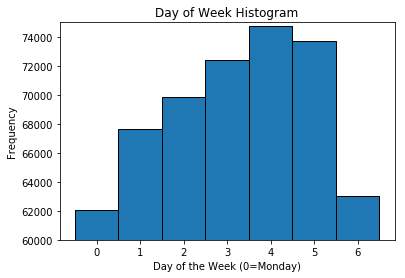

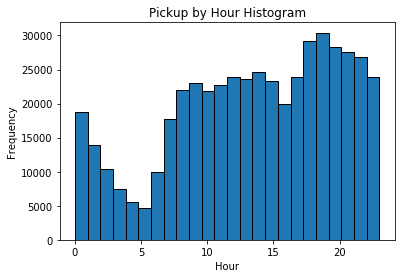

In [19]:
data['day_of_week'].plot.hist(bins=np.arange(8)-0.5, ec='black',
                             ylim=(60000, 75000))
plt.xlabel('Day of the Week (0=Monday)')
plt.title('Day of Week Histogram')
plt.show()

data['hour'].plot.hist(bins=24, ec='black')
plt.xlabel('Hour')
plt.title('Pickup by Hour Histogram')
plt.show()

It's likely that seperating out the date is going to help with the learning.

It also means that the original _pickup_datetime_ is redundant and can be dropped. We might also consider droping the year and day.

In [20]:
data.drop(['pickup_datetime', 'year', 'day'], axis=1, inplace=True)

## Feature Engineering Summary
We have seen some examples of engineering new features to enrich our data. Specicially we:
- Created a new feature (_distance_) based on a combination of existing features 
- Split an existing feature to create new features to simplify the dataset.
- Removed some (seemingly redundant) features.

There are other features that we might want to try such as:
- Zoning the Pick-up & Drop-off locations
- Flaging whether a journey was made on a National Holiday or not

In General, Feature Engineering is an iterative process. Often we will start by cleaning up our data and training the model with few engineered features. 

We can use this as a baseline and see if we can engineer new features to improve the model.

Over engineering features (particularly early in the process) can lead to poor and inflexible models. It is generally better to start simple and iteratively add engineered features.

## Normalising Data
We have numerical data that has very different ranges; for example compare the values for _passenger_count_ and the longitude and latitude features. In some datasets, the difference in ranges can be extreme (e.g. very small values compred to very large value).

This can cause issues with machine learning, leading to poor learning (slow or poor levels of accuracy) or the model becoming more sensitive to some features.

To allievate this we __Normalise__ the data; this is a mathematical operation that preserves the relationship between datapoints but brings them into similar ranges.

The downside of this is that the data no longer resembles to original dataset.

We would often do this as the last step in preparing data for a model (after pre-processing and feature engineering).

In [21]:
# Normalise the data
# get a copy of the fare_amount (since we don't want to normalise)
temp= data['fare_amount'].copy()
# Normalise the data
data = tf.keras.utils.normalize(data, axis=1)

# Replace our fare_amount data
data['fare_amount'] = temp
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,month,day_of_week,hour
0,4.5,-0.611821,0.337387,-0.611798,0.337312,0.008285,0.000078,0.049712,0.000000,0.140850
1,16.9,-0.608069,0.334458,-0.607767,0.335039,0.008215,0.000655,0.008215,0.008215,0.131446
2,5.7,-0.616957,0.339917,-0.617028,0.339827,0.016678,0.000114,0.066714,0.025018,0.000000
3,7.7,-0.616848,0.339602,-0.616885,0.339810,0.008337,0.000211,0.033349,0.041686,0.033349
4,5.3,-0.617381,0.340274,-0.617286,0.340405,0.008347,0.000163,0.025040,0.008347,0.058426


__IMPORTANT__: We Normalise the Features but we do not Normalise the target (the value we are predicting)